Alpha: 0.75, Distance Threshold: 1.3, Linkage: complete, ARI: 0.17169867110239784, NMI: 0.6818697151061416
Alpha: 0.75, Distance Threshold: 1.3, Linkage: average, ARI: 0.20356572950509144, NMI: 0.6845678606099577
Alpha: 0.75, Distance Threshold: 1.3, Linkage: single, ARI: 0.0, NMI: 0.0
Alpha: 0.75, Distance Threshold: 1.4, Linkage: complete, ARI: 0.1837063308504009, NMI: 0.6866795529424584
Alpha: 0.75, Distance Threshold: 1.4, Linkage: average, ARI: 0.28598561287718716, NMI: 0.7082400001719825
Alpha: 0.75, Distance Threshold: 1.4, Linkage: single, ARI: 0.0, NMI: 0.0
Alpha: 0.75, Distance Threshold: 1.5, Linkage: complete, ARI: 0.18613144744924215, NMI: 0.685139070296069
Alpha: 0.75, Distance Threshold: 1.5, Linkage: average, ARI: 0.3170754081351836, NMI: 0.7177827229178094
Alpha: 0.75, Distance Threshold: 1.5, Linkage: single, ARI: 0.0, NMI: 0.0
Alpha: 0.75, Distance Threshold: 1.6, Linkage: complete, ARI: 0.19843365515888264, NMI: 0.6855260397862122
Alpha: 0.75, Distance Threshold: 1.

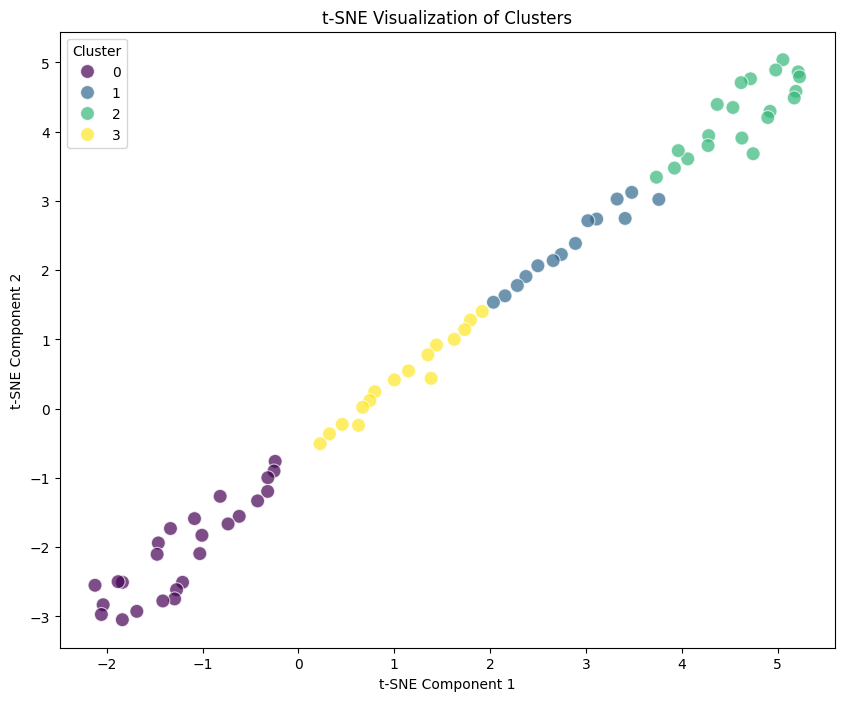

In [7]:
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from scipy.spatial.distance import pdist, squareform

# Load embeddings from file
embeddings_file = '../data/embeddings.pkl'
with open(embeddings_file, 'rb') as f:
    embeddings = pickle.load(f)

# Define custom distance function
def custom_distance(embedding1: np.ndarray, embedding2: np.ndarray, alpha: float = 0.2) -> float:
    page_num1, emb1 = int(embedding1[0]), embedding1[1:]
    page_num2, emb2 = int(embedding2[0]), embedding2[1:]
    embedding_distance = np.linalg.norm(emb1 - emb2)
    page_distance = abs(page_num1 - page_num2)
    return float(alpha * embedding_distance + (1 - alpha) * page_distance)

# Define ideal clusters
ideal_clusters = [
    (0, 0), (1, 8), (9, 11), (12, 21), (22, 29), (30, 36), (37, 38), (39, 43), (44, 45), (46, 47), (48, 48), (49, 74)
]
ideal_labels = np.zeros(len(embeddings), dtype=int)
for i, (start, end) in enumerate(ideal_clusters):
    ideal_labels[start:end+1] = i

# Function to perform clustering and evaluate
def evaluate_clustering(embeddings, alpha, distance_threshold, linkage='single'):
    page_numbers = np.arange(len(embeddings)).reshape(-1, 1)
    embeddings_with_pages = np.hstack((page_numbers, np.array(embeddings)))
    
    # Compute the custom distance matrix
    distance_matrix = squareform(pdist(embeddings_with_pages, lambda x, y: custom_distance(x, y, alpha)))
    
    clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=distance_threshold, metric='precomputed', linkage=linkage)
    labels = clustering.fit_predict(distance_matrix)
    
    # Evaluate using Adjusted Rand Index (ARI)
    ari = adjusted_rand_score(ideal_labels, labels)
    # Evaluate using Normalized Mutual Information (NMI)
    nmi = normalized_mutual_info_score(ideal_labels, labels)
    
    return ari, nmi

# Grid search over alpha, distance_threshold, and linkage
alpha_values = [0.75, 0.8, 0.825, 0.85, 0.875, 0.9, 0.925, 0.95, 1.0, 1.1, 1.2]
distance_threshold_values = [1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.15, 2.2, 2.25]
linkage_values = ['complete', 'average', 'single']
best_ari = -1
best_nmi = -1
best_params = None

for alpha in alpha_values:
    for distance_threshold in distance_threshold_values:
        for linkage in linkage_values:
            ari, nmi = evaluate_clustering(embeddings, alpha, distance_threshold, linkage)
            print(f'Alpha: {alpha}, Distance Threshold: {distance_threshold}, Linkage: {linkage}, ARI: {ari}, NMI: {nmi}')
            if ari > best_ari:
                best_ari = ari
                best_nmi = nmi
                best_params = (alpha, distance_threshold, linkage)

print(f'Best Parameters: Alpha: {best_params[0]}, Distance Threshold: {best_params[1]}, Linkage: {best_params[2]}, Best ARI: {best_ari}, Best NMI: {best_nmi}')

# Visualize the best clustering
best_alpha, best_distance_threshold, best_linkage = best_params
page_numbers = np.arange(len(embeddings)).reshape(-1, 1)
embeddings_with_pages = np.hstack((page_numbers, np.array(embeddings)))
distance_matrix = squareform(pdist(embeddings_with_pages, lambda x, y: custom_distance(x, y, best_alpha)))
clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=best_distance_threshold, metric='precomputed', linkage=best_linkage)
labels = clustering.fit_predict(distance_matrix)

# Dimensionality reduction using t-SNE
tsne = TSNE(n_components=2, metric='precomputed', init='random', random_state=42)
embeddings_2d = tsne.fit_transform(distance_matrix)

# Plot the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], hue=labels, palette='viridis', s=100, alpha=0.7)
plt.title('t-SNE Visualization of Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster')
plt.show()